In [2]:
# Installs 

# !pip install mlflow dagshub progressbar2 GPUtil

In [4]:
# Imports

from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms, utils
from torch import nn, optim
from PIL import Image
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch import flatten
from torchmetrics import MeanSquaredError
import progressbar

import dagshub
import mlflow

from GPUtil import showUtilization as gpu_usage
from numba import cuda


# CSV files

DIR_PATH = "/kaggle/input/facial-keypoints-detection/"
training_data = pd.read_csv(f"{DIR_PATH}training.zip")
training_data = training_data.dropna()
test_data = pd.read_csv(f"{DIR_PATH}test.zip")
id_lookup_table = pd.read_csv(f"{DIR_PATH}IdLookupTable.csv")

# Params

@dataclass
class ModelParams:
    BATCH_SIZE: int = 128
    VALID_SIZE: float = 0.2
    N_EPOCHS: int = 15
    IMG_SIZE: int = 96
    OUTPUT_SIZE: int = 30 
    LEARNING_RATE: float = 0.03  

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic=True

dagshub.init("facial_reg_model", "caddis90", mlflow=True)

mlflow.set_tracking_uri('https://dagshub.com/caddis90/facial_reg_model.mlflow')
mlflow.set_experiment(experiment_name="cnn")

Repository initialized!

<Experiment: artifact_location='mlflow-artifacts:/626852b5f0d64f76a22d0244445f3383', creation_time=1682621968764, experiment_id='0', last_update_time=1682621968764, lifecycle_stage='active', name='cnn', tags={}>

In [40]:
# GPU 

def free_gpu_cache():
    print("Initial GPU usage")
    gpu_usage()                             

    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU usage after emptying the cache")
    gpu_usage()
    

# Data 

class FacialKeypointsDataset(Dataset):
    
    def __init__(self, dataset, train=True, transform=None):
        self.dataset = dataset.dropna()
        self.train = train
        self.transform = transform

    def get_image(self, idx):
        image = np.fromstring(self.dataset.iloc[idx, -1], sep=' ')
        image = image.astype(np.float32)
        image = image.reshape(ModelParams.IMG_SIZE, ModelParams.IMG_SIZE, 1) 
        return image
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):        
        if self.train:
            keypoints = self.dataset.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None

        sample = {'image': self.get_image(idx), 'keypoints': keypoints}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


def prepare_dataloaders(dataset, valid_size, batch_size):
    dataset_len = len(dataset)
    dataset_indices = list(range(dataset_len))
    np.random.shuffle(dataset_indices)
    split = int(np.floor(valid_size * dataset_len))
    train_idx, valid_idx = dataset_indices[split:], dataset_indices[:split]
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
    valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))
    
    return train_loader, valid_loader

# Transforms

class Normalize():    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., 'keypoints': keypoints}
        
        
class ToTensor():
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # NumPy image: H x W x C versus Torch image: C X H X W
        image_height = image.shape[0]
        image_width = image.shape[1]
        image = image.reshape(1, image_height, image_width)
        
        if keypoints is not None:
            return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(keypoints)}
        else:
            return {'image': torch.from_numpy(image)}
        
        
class SquareImageRescale():
    def __init__(self, output_size: int=250):
        self.output_size = output_size
        
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']        
            
        image = cv2.resize(image, (self.output_size, self.output_size))
        scale_factor = self.output_size / ModelParams.IMG_SIZE
        keypoints = keypoints * scale_factor
        
        return {'image': image, 'keypoints': keypoints}
    
    
class BrightnessAugmentation():
    def __init__(self, factor: float = -1):
        self.factor = factor
        
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']    
        image = np.clip(image + self.factor, -1, 1)
        
        return {'image': image, 'keypoints': keypoints}
        
        
class NoiseAugmentation():
    def __init__(self, factor: float = 0.008):
        self.factor = factor
        
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']    
        image = image + self.factor
        
        return {'image': image, 'keypoints': keypoints}

# Utilities

def create_submission(predictions, id_lookup_table=id_lookup_table):
    features_n = list(id_lookup_table['FeatureName'])
    img_ids = list(id_lookup_table['ImageId']-1) 

    features_lst = [features_n.index(feature) for feature in features_n]

    submission = pd.DataFrame({
        "RowId": list(id_lookup_table['RowId']),
        "Location": [predictions[x][y] for x, y in zip(img_ids, features_lst)]
    })
    submission.to_csv("submission.csv",index = False)
    

def show_image(image, training_key_points, test_key_points=[], transform=None):
    if transform: 
        train_sample = transform(sample={"image": image, "keypoints": training_key_points})
        image, training_key_points = train_sample["image"], train_sample["keypoints"]
        
    plt.imshow(image, cmap="gray")

    training_key_points = training_key_points.reshape([15, 2])
    plt.plot(training_key_points[:,0], training_key_points[:,1], 'gx')
    
    if len(test_key_points) > 0:
        if transform: 
            test_sample = transform(sample={"image": image, "key_points": test_key_points})
            image, test_key_points = sample["image"], sample["key_points"]
            
        test_key_points = test_key_points.reshape([15, 2])
        plt.plot(test_key_points[:,0], test_key_points[:,1], 'rx')

            
# Models 

class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64*12*12, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=output_size)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        """
        2D Convolution and Pooling
        ---------------------------
        (N, C_IN, H_IN, W_IN) -> (N, C_OUT, H_OUT, W_OUT)
        H_OUT = (H_IN + 2 * PADDING - DILATION - (KERNEL_SZ-1) - 1) / STRIDE + 1
        W_OUT = (W_IN + 2 * PADDING - DILATION - (KERNEL_SZ-1) - 1) / STRIDE + 1
        
        Fully Connected 
        ---------------
        (H_IN, W_IN) * (H_FC, W_FC) = (H_IN, W_FC)
        """
        
        x = self.conv1(x) 
        x = F.relu(x)
        # torch.Size([128, 1, 96, 96]) -> torch.Size([128, 16, 48, 48])
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        # torch.Size([128, 16, 48, 48]) -> torch.Size([128, 32, 24, 24])
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        # torch.Size([128, 32, 24, 24]) -> torch.Size([128, 64, 12, 12])
        x = self.pool(x)
        
        # torch.Size([128, 64, 12, 12]) -> torch.Size([128, 9216])
        x = x.view(-1, 64*12*12)
        x = self.dropout(x)
        
        # torch.Size([128, 9216]) -> torch.Size([128, 1024])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # torch.Size([128, 1024]) -> torch.Size([128, 30])
        x = self.fc2(x)

        return x

resnet50 = models.resnet50(num_classes = ModelParams.OUTPUT_SIZE)
resnet50.inplanes = ModelParams.IMG_SIZE
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [14]:
transformations = transforms.Compose([Normalize(), ToTensor()])

trainset = FacialKeypointsDataset(training_data, transform=transformations)
testset = FacialKeypointsDataset(test_data, train=False, transform=transformations)

train_loader, valid_loader = prepare_dataloaders(
        trainset, 
        valid_size=ModelParams.VALID_SIZE, 
        batch_size=ModelParams.BATCH_SIZE
)
test_loader = DataLoader(testset, batch_size=ModelParams.BATCH_SIZE)

#model = CNN(output_size=ModelParams.OUTPUT_SIZE)
model = resnet50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")
model = model.to(device)

criterion = nn.MSELoss().to(device)
rmse = MeanSquaredError(squared=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=ModelParams.LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)

Using cuda


In [18]:
with mlflow.start_run():
    mlflow.set_tag("transforms", "Compose([Normalize(), SquareImageRescale(), ToTensor()])")
    mlflow.log_params(asdict(ModelParams()))
    for epoch in progressbar.progressbar(range(ModelParams.N_EPOCHS)):
        epoch_train_loss, epoch_valid_loss = 0.0, 0.0

        model.train() 
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(batch['image'].to(device))
            loss = criterion(output, batch['keypoints'].to(device))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()*batch['image'].size(0)
            batch_train_rmse = rmse(output.cpu(), batch['keypoints'].cpu())
            
        epoch_train_rmse = rmse.compute()
        rmse.reset()
        scheduler.step()

        with torch.no_grad():
            model.eval() 
            for i, batch in enumerate(valid_loader):
                output = model(batch['image'].to(device))
                loss = criterion(output, batch['keypoints'].to(device))
                epoch_valid_loss += loss.item()*batch['image'].size(0)
                batch_valid_rmse = rmse(output.cpu(), batch['keypoints'].cpu())

            epoch_valid_rmse = rmse.compute()
            rmse.reset()
        
            epoch_train_loss = np.sqrt(epoch_train_loss/len(train_loader.sampler.indices))
            epoch_valid_loss = np.sqrt(epoch_valid_loss/len(valid_loader.sampler.indices))

            mlflow.log_metric("train_loss", epoch_train_loss, step=epoch)
            mlflow.log_metric("valid_loss", epoch_valid_loss, step=epoch)
            mlflow.log_metric("train_rmse", epoch_train_rmse, step=epoch)
            mlflow.log_metric("valid_rmse", epoch_valid_rmse, step=epoch)

100% (15 of 15) |########################| Elapsed Time: 0:04:28 Time:  0:04:28


In [6]:
model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        output = model(batch['image'].to(device)).cpu().numpy()
        output = np.clip(output, a_min=0, a_max=96)
        if i == 0:
            test_predictions = output
        else:
            test_predictions = np.vstack((test_predictions, output))
    
create_submission(test_predictions)

In [ ]:
model.eval()
with torch.no_grad():
    test_key_points = model(plot_sample['image'].unsqueeze(0).to(device)).cpu().numpy()

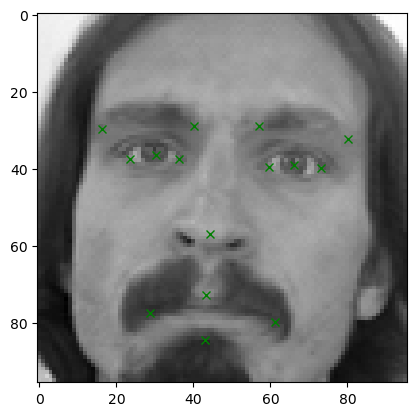

In [41]:
plot_sample = trainset[0]
image = plot_sample["image"].numpy()
image_height = image.shape[1]
image_width = image.shape[2]
image = image.reshape(image_height, image_width, 1)   
show_image(image=image, training_key_points=plot_sample["keypoints"].numpy(), transform=BrightnessAugmentation())#, test_key_points=test_key_points)